In [1]:
from pathlib import Path
from typing import List
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import os

sns.set(rc={'figure.figsize':(20,14)})

In [2]:
BASELINE_CODEC = "bytepacking_Hyrise_fsba"
NUM_CLIENTS = 1

# put all relevant files into this folder.
# make sure to rename them with ./renameM1Measurements.sh
# 
data_folder = f"../data/columnCompressionM1Martin_{NUM_CLIENTS}"

benchmarks = [
    "TPCH",
    "TPCDS",
    "Jo"
]

for benchmark in benchmarks:
    os.system(f"cd {data_folder} && mkdir {benchmark} && mv hyriseBenchmark{benchmark}* {benchmark}")
    os.system(f"p=$(pwd) && cd {data_folder}/{benchmark} && python3 $p/benchmark_to_csv.py . && mkdir sizes && cp ../../sizes/sizes_{benchmark}/* ./sizes")

data_folders = [data_folder + "/" + benchmark for benchmark in benchmarks]

print(data_folders)

['../data/columnCompressionM1Martin_1/TPCH', '../data/columnCompressionM1Martin_1/TPCDS', '../data/columnCompressionM1Martin_1/Jo']


In [3]:
def fancy_name(benchmark_name):
    a = benchmark_name.replace(".json", "").replace("_LTO", "").replace("_singlethreaded", "").replace("","")[2:]
    b = a.split("_")
    a = "_".join(b[1:])
    return map_benchmark_name(a)

def map_benchmark_name(b):
    return b \
        .replace("compactvector_f", "compactvector_16") \
        .replace("compressionUnencoded", "unencoded_Hyrise") \
        .replace("dictionary", "bytepacking_Hyrise_fsba") \
        .replace("bitpacking_simdcai", "for_SIMDCAI_simd") \
        .replace("bitpacking_turbopfor", "bitpacking_turboPFOR") \
        .replace("simdbp", "simdbp128_Hyrise") \
        .replace("sizes_", "") \
        .replace(".txt", "")

def get_high_level_multi(data_folder, name):
    os.system(f"p=$(pwd) && cd {data_folder} && python3 $p/benchmark_to_csv.py .")

    high_level = pd.read_csv(f"{data_folder}/benchmarks_parsed_high_level.csv")
    high_level = high_level.sort_values("benchmark_run_name")
    #high_level = high_level[~high_level["benchmark_run_name"].str.match(".*simdbp.*")]
    high_level["fancy_name"] = [fancy_name(b) for b in high_level["benchmark_run_name"]]
    high_level["codec_name"] = ["_".join(b.split("_")[:len(b.split("_")) - 2]) for b in high_level["fancy_name"]]
    high_level["num_clients"] = [int(b.split("_")[len(b.split("_")) - 2]) for b in high_level["fancy_name"]] 
    # assumes naming like hyriseBenchmarkTPCH_bitpacking_compactvector_f_6_shuffled, also for singlethreaded. Rename the _singlethreaded files with something like: 
    # zmv '(*)_singlethreaded.json' '$1_1_shuffled.json'
    # 
    high_level = high_level.sort_values("num_clients")
    high_level["benchmark"] = name
    
    base = high_level[high_level["fancy_name"].str.match(f".*{BASELINE_CODEC}_{NUM_CLIENTS}_shuffled")]["total_runtime"].values[0]
    high_level["relative_runtime"] = high_level["total_runtime"] / base

    all_h = []
    for n in high_level.num_clients.unique():
        h_n = high_level[high_level.num_clients == n]
        base = h_n[h_n["codec_name"] == BASELINE_CODEC]["total_runtime"].values[0]
        h_n["relative_runtime"] = h_n["total_runtime"] / base
        all_h.append(h_n)

    a = pd.concat(all_h)

    a["total_throughput"] = a.avg_throughput * a.num_clients


    b = pd.DataFrame({"codec": a.codec_name,"throughput": a.avg_throughput, "total_runtime": a.total_runtime, "benchmark": a.benchmark, "num_clients": a.num_clients, "relative_runtime": a.relative_runtime, "total_throughput": a.total_throughput})
    

    return b


high_level_all_benchmarks = [get_high_level_multi(folder, benchmark) for benchmark, folder in zip(benchmarks, data_folders)]
multi_benchmarks = pd.concat(high_level_all_benchmarks)

multi_benchmarks

,codec,throughput,total_runtime,benchmark,num_clients,relative_runtime,total_throughput
0,bitpacking_compactvector,7.267933,7.490206e+09,TPCH,1,1.065747,7.267933
1,bitpacking_compactvector_16,7.637077,7.204845e+09,TPCH,1,1.025145,7.637077
2,unencoded_Hyrise,7.698386,7.261397e+09,TPCH,1,1.033191,7.698386
3,bytepacking_Hyrise_fsba,7.922654,7.028126e+09,TPCH,1,1.000000,7.922654
1,bitpacking_compactvector,12.056935,6.372394e+09,TPCDS,1,1.105686,12.056935
2,bitpacking_compactvector_16,12.839111,5.959224e+09,TPCDS,1,1.033996,12.839111
3,unencoded_Hyrise,13.018624,5.901424e+09,TPCDS,1,1.023967,13.018624
0,bytepacking_Hyrise_fsba,13.338948,5.763293e+09,TPCDS,1,1.000000,13.338948
3,bitpacking_compactvector,1.761412,1.475409e+11,Jo,1,1.029875,1.761412
2,bitpacking_compactvector_16,1.816092,1.446399e+11,Jo,1,1.009626,1.816092


In [4]:

def get_high_level(data_folder):
    high_level = pd.read_csv(f"{data_folder}/benchmarks_parsed_high_level.csv")
    high_level = high_level.sort_values("benchmark_run_name")
    # high_level = high_level[~high_level["benchmark_run_name"].str.match(".*simdbp.*")]
    high_level["fancy_name"] = [fancy_name(b) for b in high_level["benchmark_run_name"]]
    high_level["codec_name"] = ["_".join(b.split("_")[:len(b.split("_")) - 2]) for b in high_level["fancy_name"]]
    high_level["LTO"] = high_level["benchmark_run_name"].str.match(".*LTO.*")
    return high_level

def load_table(path: Path) -> DataFrame:
    all_entries: List[List[str]] = []
    av_dict_entries: List[List[int]] = []
    column_names: List[str] = []
    types: List[str] = []
    with path.open() as file:
        table_starts: bool = False
        for line in file:
            if not table_starts and "attribute_vector_size" in line:
                e = [entry for entry in line.split(",") if entry != "" and entry != "\n"]
                av_dict_entries.append([int(e[1]), int(e[3])])
            if len(column_names) != 0 and table_starts and not '|' in line:
                break
            if not '|' in line:
                continue
            if len(column_names) == 0:
                column_names = [entry.replace(" ", "")
                                for entry in line.split("|") if entry != "" and entry != "\n"]
                continue
            if len(types) == 0:
                types =  [entry.replace(" ", "")
                          for entry in line.split("|") if entry != "" and entry != "\n"]
                continue
            if "<ValueS>" in line:
                table_starts = True
                continue
            if not table_starts:
                continue
            new_entry: List[str] = [entry.replace(" ", "")
                                    for entry in line.split("|") if entry != "" and entry != "\n"]
            all_entries.append(new_entry)
    as_type: Dict[str, str] = {column_names[i]:types[i] for i in range(0, len(column_names))}

    entries = [a + b for a,b, in zip(all_entries, av_dict_entries)]
    column_names = column_names + ["attribute_vector_size", "dict_size"]
    df = DataFrame(data=entries, columns=column_names).astype(as_type)

    df["dict_size"] = [1 if d == 0 else d for d in df["dict_size"]]
    df["duplication_factor"] = df["attribute_vector_size"] / df["dict_size"]

    df = df.astype({'duplication_factor': 'int32'})

    return df

def compute_sizes(df):
    total_size = df["size_in_bytes"].sum()

    int_col_size = df[df["column_data_type"].str.match("int")]["size_in_bytes"].sum()
    float_col_size = df[df["column_data_type"].str.match("float")]["size_in_bytes"].sum()
    string_col_size = df[df["column_data_type"].str.match("string")]["size_in_bytes"].sum()

    return (total_size, int_col_size, float_col_size, string_col_size)

def get_df(data_path, benchmark_name):
    os.system(f"p=$(pwd) && cd {data_path} && python3 $p/benchmark_to_csv.py .")

    high_level = get_high_level(data_path)
    #high_level["fancy_name"] = [n[2:] for n in high_level["fancy_name"]]
    default_filename = "sizes_compressionUnencoded.txt"
    default = load_table(Path(data_path) / "sizes" / default_filename)

    grouped_by_column = default.groupby(["table_name", "column_name", "column_data_type"], as_index=False)["size_in_bytes"].sum()
    columns_per_data_type = grouped_by_column.groupby(["column_data_type"], as_index=False)["column_name"].count()
    size_per_data_type = grouped_by_column.groupby(["column_data_type"], as_index=False)["size_in_bytes"].sum()
    #print("number of columns per datatype")
    #print(columns_per_data_type)



    (default_size, default_int_col_size, default_float_col_size, default_string_col_size) = compute_sizes(default)
    #print("default dict size ", default_size)
    #print("default dict int col size ", default_int_col_size)
    #print("default int col portion of size ", default_int_col_size / default_size)


    names = []
    total_sizes = []
    int_col_sizes = []
    float_col_sizes = []
    string_col_sizes = []
    directory = os.fsencode(Path(data_path) / "sizes")
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".txt"):
            p = Path(data_path) / "sizes" / filename
            #print(p)
            du = load_table(p)
            #print(du)
            #print(df)
            names.append(filename)
            print(benchmark_name, filename)
            (total_size, int_col_size, float_col_size, string_col_size) = compute_sizes(du)
            total_sizes.append(total_size)
            int_col_sizes.append(int_col_size)
            float_col_sizes.append(float_col_size)
            string_col_sizes.append(string_col_size)

                
    df = pd.DataFrame(data={'filename': names, 'total_size': total_sizes, 'int_col_sizes': int_col_sizes, 'float_col_sizes': float_col_sizes, 'string_col_sizes': string_col_sizes})
    df["codec"] = [fancy_name(f) for f in df["filename"]]
    df = df.sort_values("codec")

    
    d = df.merge(high_level, left_on="codec", right_on="codec_name")
    #print(df)
    #print(high_level)
    d["total_size"] = d["total_size"] / 10**9
    d["total_runtime"] = d["total_runtime"] / 10**9

    
    
    base = d[d["codec"] == BASELINE_CODEC]["total_runtime"].values[0]
    d["relative_runtime"] = d["total_runtime"] / base

    d["benchmark"] = benchmark_name

    d["num_clients"] = 1

    d["total_throughput"] = d.avg_throughput * d.num_clients

    d_1 = pd.DataFrame({"codec": d.codec,"throughput": d.avg_throughput, "total_runtime": d.total_runtime, "benchmark": d.benchmark, "num_clients": d.num_clients, "relative_runtime": d.relative_runtime, "total_throughput": d.total_throughput})
    return d_1


all_single = [get_df(folder, benchmark) for benchmark, folder in zip(benchmarks, data_folders)]
single_benchmarks = pd.concat(all_single)
single_benchmarks

TPCH sizes_bitpacking_compactvector.txt
TPCH sizes_bitpacking_turbopfor.txt
TPCH sizes_compressionUnencoded.txt
TPCH sizes_bitpacking_simdcai_seq.txt
TPCH sizes_bitpacking_turbopfor_seq.txt
TPCH sizes_dictionary.txt
TPCH sizes_bitpacking_compactvector_f.txt
TPCH sizes_bitpacking_simdcai.txt
TPCH sizes_simdbp.txt
TPCDS sizes_bitpacking_compactvector.txt
TPCDS sizes_bitpacking_turbopfor.txt
TPCDS sizes_compressionUnencoded.txt
TPCDS sizes_bitpacking_simdcai_seq.txt
TPCDS sizes_bitpacking_turbopfor_seq.txt
TPCDS sizes_dictionary.txt
TPCDS sizes_bitpacking_compactvector_f.txt
TPCDS sizes_bitpacking_simdcai.txt
TPCDS sizes_simdbp.txt
Jo sizes_bitpacking_compactvector.txt
Jo sizes_bitpacking_turbopfor.txt
Jo sizes_compressionUnencoded.txt
Jo sizes_bitpacking_simdcai_seq.txt
Jo sizes_bitpacking_turbopfor_seq.txt
Jo sizes_dictionary.txt
Jo sizes_bitpacking_compactvector_f.txt
Jo sizes_bitpacking_simdcai.txt
Jo sizes_simdbp.txt


,codec,throughput,total_runtime,benchmark,num_clients,relative_runtime,total_throughput
0,bitpacking_compactvector,7.267933,7.490206,TPCH,1,1.065747,7.267933
1,bitpacking_compactvector_16,7.637077,7.204845,TPCH,1,1.025145,7.637077
2,bytepacking_Hyrise_fsba,7.922654,7.028126,TPCH,1,1.000000,7.922654
3,unencoded_Hyrise,7.698386,7.261397,TPCH,1,1.033191,7.698386
0,bitpacking_compactvector,12.056935,6.372394,TPCDS,1,1.105686,12.056935
1,bitpacking_compactvector_16,12.839111,5.959224,TPCDS,1,1.033996,12.839111
2,bytepacking_Hyrise_fsba,13.338948,5.763293,TPCDS,1,1.000000,13.338948
3,unencoded_Hyrise,13.018624,5.901424,TPCDS,1,1.023967,13.018624
0,bitpacking_compactvector,1.761412,147.540874,Jo,1,1.029875,1.761412
1,bitpacking_compactvector_16,1.816092,144.639943,Jo,1,1.009626,1.816092


In [5]:
def get_sizes(data_path, name):
    names = []
    total_sizes = []
    int_col_sizes = []
    float_col_sizes = []
    string_col_sizes = []
    directory = os.fsencode(Path(data_path) / "sizes")
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".txt"):
            p = Path(data_path) / "sizes" / filename
            #print(p)
            du = load_table(p)
            #print(du)
            #print(df)
            names.append(filename)
            (total_size, int_col_size, float_col_size, string_col_size) = compute_sizes(du)
            total_sizes.append(total_size)
            int_col_sizes.append(int_col_size)
            float_col_sizes.append(float_col_size)
            string_col_sizes.append(string_col_size)

    df = pd.DataFrame(data={'filename': names, 'total_size': total_sizes, 'int_col_sizes': int_col_sizes, 'float_col_sizes': float_col_sizes, 'string_col_sizes': string_col_sizes})
    #print(df)
    df["codec"] = [fancy_name(f) for f in df["filename"]]
    df = df.sort_values("codec")
    df["benchmark"] = name
    return df


all_sizes = pd.concat([get_sizes(folder, benchmark) for folder, benchmark in zip(data_folders, benchmarks)])
all_sizes

,filename,total_size,int_col_sizes,float_col_sizes,string_col_sizes,codec,benchmark
0,sizes_bitpacking_compactvector.txt,9868210083,1445245248,664533612,7758431223,bitpacking_compactvector,TPCH
6,sizes_bitpacking_compactvector_f.txt,11316269827,1609638576,989767660,8716863591,bitpacking_compactvector_16,TPCH
1,sizes_bitpacking_turbopfor.txt,9582567033,1317708016,600855186,7664003831,bitpacking_turboPFOR,TPCH
4,sizes_bitpacking_turbopfor_seq.txt,9582567033,1317708016,600855186,7664003831,bitpacking_turboPFOR_seq,TPCH
5,sizes_dictionary.txt,9999839546,1372782099,676386560,7950670887,bytepacking_Hyrise_fsba,TPCH
7,sizes_bitpacking_simdcai.txt,9567344611,1315743428,600776428,7650824755,for_SIMDCAI_simd,TPCH
3,sizes_bitpacking_simdcai_seq.txt,9567344611,1315743428,600776428,7650824755,for_SIMDCAI_simd_seq,TPCH
8,sizes_simdbp.txt,9552397107,1307080816,602595564,7642720727,simdbp128_Hyrise,TPCH
2,sizes_compressionUnencoded.txt,13063740127,2083656732,1389433132,9590650263,unencoded_Hyrise,TPCH
0,sizes_bitpacking_compactvector.txt,6394814239,2901572456,3357457448,135784335,bitpacking_compactvector,TPCDS


In [6]:
all_benchmarks = pd.concat([single_benchmarks, multi_benchmarks])
all_benchmarks

,codec,throughput,total_runtime,benchmark,num_clients,relative_runtime,total_throughput
0,bitpacking_compactvector,7.267933,7.490206e+00,TPCH,1,1.065747,7.267933
1,bitpacking_compactvector_16,7.637077,7.204845e+00,TPCH,1,1.025145,7.637077
2,bytepacking_Hyrise_fsba,7.922654,7.028126e+00,TPCH,1,1.000000,7.922654
3,unencoded_Hyrise,7.698386,7.261397e+00,TPCH,1,1.033191,7.698386
0,bitpacking_compactvector,12.056935,6.372394e+00,TPCDS,1,1.105686,12.056935
1,bitpacking_compactvector_16,12.839111,5.959224e+00,TPCDS,1,1.033996,12.839111
2,bytepacking_Hyrise_fsba,13.338948,5.763293e+00,TPCDS,1,1.000000,13.338948
3,unencoded_Hyrise,13.018624,5.901424e+00,TPCDS,1,1.023967,13.018624
0,bitpacking_compactvector,1.761412,1.475409e+02,Jo,1,1.029875,1.761412
1,bitpacking_compactvector_16,1.816092,1.446399e+02,Jo,1,1.009626,1.816092


In [7]:
data = all_benchmarks[~all_benchmarks["codec"].str.match(".*_seq")]
data = data[data["num_clients"] == NUM_CLIENTS]
data = data[data["total_runtime"] > 9e+03] # no time to investigate where the duplicates come from
data = data.merge(all_sizes, on=["codec", "benchmark"])
data

,codec,throughput,total_runtime,benchmark,num_clients,relative_runtime,total_throughput,filename,total_size,int_col_sizes,float_col_sizes,string_col_sizes
0,bitpacking_compactvector,7.267933,7.490206e+09,TPCH,1,1.065747,7.267933,sizes_bitpacking_compactvector.txt,9868210083,1445245248,664533612,7758431223
1,bitpacking_compactvector_16,7.637077,7.204845e+09,TPCH,1,1.025145,7.637077,sizes_bitpacking_compactvector_f.txt,11316269827,1609638576,989767660,8716863591
2,unencoded_Hyrise,7.698386,7.261397e+09,TPCH,1,1.033191,7.698386,sizes_compressionUnencoded.txt,13063740127,2083656732,1389433132,9590650263
3,bytepacking_Hyrise_fsba,7.922654,7.028126e+09,TPCH,1,1.000000,7.922654,sizes_dictionary.txt,9999839546,1372782099,676386560,7950670887
4,bitpacking_compactvector,12.056935,6.372394e+09,TPCDS,1,1.105686,12.056935,sizes_bitpacking_compactvector.txt,6394814239,2901572456,3357457448,135784335
5,bitpacking_compactvector_16,12.839111,5.959224e+09,TPCDS,1,1.033996,12.839111,sizes_bitpacking_compactvector_f.txt,7790698559,4192303712,3434407032,163987815
6,unencoded_Hyrise,13.018624,5.901424e+09,TPCDS,1,1.023967,13.018624,sizes_compressionUnencoded.txt,10902447315,6207424816,4506051348,188971151
7,bytepacking_Hyrise_fsba,13.338948,5.763293e+09,TPCDS,1,1.000000,13.338948,sizes_dictionary.txt,6257970805,3041190559,3075083052,141697194
8,bitpacking_compactvector,1.761412,1.475409e+11,Jo,1,1.029875,1.761412,sizes_bitpacking_compactvector.txt,6849373232,1913531024,0,4935842208
9,bitpacking_compactvector_16,1.816092,1.446399e+11,Jo,1,1.009626,1.816092,sizes_bitpacking_compactvector_f.txt,7576651048,2463914328,0,5112736720


In [8]:

for b in data["benchmark"].unique():
    df = data[data["benchmark"] == b]
    baseline_unencoded = df[df["codec"] == "unencoded_Hyrise"]
    data.loc[data["benchmark"] == b,"relative_size"] = df["total_size"] / float(baseline_unencoded["total_size"])
    data.loc[data["benchmark"] == b,"relative_runtime_1"] = df["total_runtime"] / float(baseline_unencoded["total_runtime"])

data = data.sort_values(["benchmark","codec"], ascending=False)
data["relative_size"] = [1.0, 0.659, 0.696, 0.633, 1.0, 0.491, 0.567, 0.388, 1.0, 0.573, 0.642, 0.514]


data

,codec,throughput,total_runtime,benchmark,num_clients,relative_runtime,total_throughput,filename,total_size,int_col_sizes,float_col_sizes,string_col_sizes,relative_size,relative_runtime_1
2,unencoded_Hyrise,7.698386,7.261397e+09,TPCH,1,1.033191,7.698386,sizes_compressionUnencoded.txt,13063740127,2083656732,1389433132,9590650263,1.000,1.000000
3,bytepacking_Hyrise_fsba,7.922654,7.028126e+09,TPCH,1,1.000000,7.922654,sizes_dictionary.txt,9999839546,1372782099,676386560,7950670887,0.659,0.967875
1,bitpacking_compactvector_16,7.637077,7.204845e+09,TPCH,1,1.025145,7.637077,sizes_bitpacking_compactvector_f.txt,11316269827,1609638576,989767660,8716863591,0.696,0.992212
0,bitpacking_compactvector,7.267933,7.490206e+09,TPCH,1,1.065747,7.267933,sizes_bitpacking_compactvector.txt,9868210083,1445245248,664533612,7758431223,0.633,1.031510
6,unencoded_Hyrise,13.018624,5.901424e+09,TPCDS,1,1.023967,13.018624,sizes_compressionUnencoded.txt,10902447315,6207424816,4506051348,188971151,1.000,1.000000
7,bytepacking_Hyrise_fsba,13.338948,5.763293e+09,TPCDS,1,1.000000,13.338948,sizes_dictionary.txt,6257970805,3041190559,3075083052,141697194,0.491,0.976594
5,bitpacking_compactvector_16,12.839111,5.959224e+09,TPCDS,1,1.033996,12.839111,sizes_bitpacking_compactvector_f.txt,7790698559,4192303712,3434407032,163987815,0.567,1.009794
4,bitpacking_compactvector,12.056935,6.372394e+09,TPCDS,1,1.105686,12.056935,sizes_bitpacking_compactvector.txt,6394814239,2901572456,3357457448,135784335,0.388,1.079806
10,unencoded_Hyrise,1.855472,1.439989e+11,Jo,1,1.005151,1.855472,sizes_compressionUnencoded.txt,8841091748,3366120724,0,5474971024,1.000,1.000000
11,bytepacking_Hyrise_fsba,1.874838,1.432609e+11,Jo,1,1.000000,1.874838,sizes_dictionary.txt,6850630005,1927429163,0,4923200842,0.573,0.994875


In [9]:
data["codec"].unique()

array(['unencoded_Hyrise', 'bytepacking_Hyrise_fsba',
       'bitpacking_compactvector_16', 'bitpacking_compactvector'],
      dtype=object)

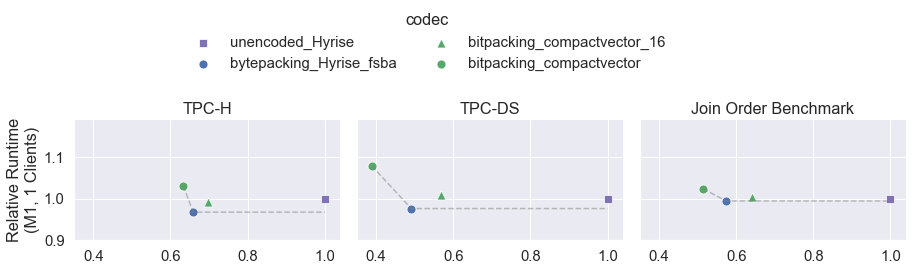

In [10]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set(rc={'figure.figsize':(23,8)})
sns.set(font_scale=1.35)

palette = {
    "unencoded_Hyrise" : "red",
    "bytepacking_Hyrise_fsba" : "blue",
    "bitpacking_compactvector_16": "green",
    "bitpacking_compactvector" : "green",
}

markers = {
    "unencoded_Hyrise" : "s",
    "bytepacking_Hyrise_fsba" : "o",
    "bitpacking_compactvector_16": "^",
    "bitpacking_compactvector" : "o",
}

orders = ['unencoded_Hyrise', 'bytepacking_Hyrise_fsba', 'bitpacking_compactvector_16', "bitpacking_compactvector"]

hue_kws = {'marker': ["s", "o", "^", "o"],
          'color': ['#8172b3', '#4c72af', "#55a868", "#55a868"]}

g = sns.FacetGrid(data, col="benchmark", hue="codec", hue_kws=hue_kws, legend_out=True, height=3.0, aspect=1.5)
g.map(sns.scatterplot, "relative_size", "relative_runtime_1", s=80)
g.set_axis_labels("Relative Total Column Size\n(Baseline Unencoded)", f"Relative Runtime\n(M1, {NUM_CLIENTS} Clients)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, bbox_to_anchor=(.5, 1), loc='lower right')

def pareto_frontier(Xs, Ys, maxX=False, maxY=False):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    
    return pareto_front

benchmark_chart_names = {
    "Jo": "Join Order Benchmark",
    "TPCH": "TPC-H",
    "TPCDS": "TPC-DS"
}


for ax in g.axes[0]:
    benchmark = ax.title.get_text()
    data_for_benchmark = data[data["benchmark"] == benchmark]
    x = list(data_for_benchmark["relative_size"])
    y = list(data_for_benchmark["relative_runtime_1"])
    par = pareto_frontier(x, y)
    par.insert(0, [min(x), max(y)])
    par.append([max(x), par[-1][1]])
    ax.set_title(benchmark_chart_names[benchmark])
    ax.plot([p[0] for p in par], [p[1] for p in par], color="grey", linestyle="dashed", alpha=0.5)
    x_max_index = x.index(max(x))
    ax.set(xlim=(0.35 * max(x), max(x) * 1.04), ylim=(0.9* y[x_max_index], 1.19 * y[x_max_index]))
    
    #ax.set_title("")
    ax.set_xlabel("")

plt.savefig(f"visualizations/columncompression_pareto_M1_{NUM_CLIENTS}.svg", format="svg")
plt.savefig(f"visualizations/columncompression_pareto_M1_{NUM_CLIENTS}.png", format="png",  bbox_inches='tight')